# ML MODELS TO  PREDICT ATMOSPHERIC EMISSIONS GROUP PROJECT

# 1. Overview
This notebook features the steps taken to examine datasets from the London Atmospheric Emissions Inventory (LAEI) 2013 datasets in order to glean predictive insight and produce machine learning models from the data.

The source datasets can be found [here.](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013)

## 1.1 Importing Libraries
Firstly, relevant library are imported which are used throughout this notebook.

This includes [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), various elements from [scikit learning](https://scikit-learn.org/stable/) as well as other miscellaneous imports.

In [1]:
import pandas as pd
import numpy as np
from functools import reduce

# Feature selection and data splitting
from sklearn import preprocessing
from sklearn import feature_selection
import seaborn as sns

# ML regression algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate

# Regression performance metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Increase maximum columns displayed by pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', None)

# Remove displayed warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Data Processing
The first step in the process is to view the raw dataset and transform into an examinable format.

## 2.1  Emissions by Link

### 2.1.1 Loading Data
The first dataset is one that contaims at link level the number of emissions by vehicle type.

This dataset can be found within the `3 - Detailed Road Transport` files [here](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013).
- LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx
    - Sheet 1: 2013 LTS Rds
    - Sheet 2: 2013 Other Major Rds

Below, the data is loaded into the code and the shape is printed.

In [2]:
%%time

df_2013_EmissionsbyLink = pd.read_excel("datasets\LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx", sheet_name=[0, 1])

# The above file contains two sheets
df_2013_LTS_Rds = df_2013_EmissionsbyLink[0]
df_2013_Other_Major_Rds = df_2013_EmissionsbyLink[1]

print(df_2013_LTS_Rds.shape)
print(df_2013_Other_Major_Rds.shape)

# Add the sheet name in a new column to differentiate between LTS and Other Major Roads
df_2013_LTS_Rds["EmissinsbyLink_sheet"] = "LTS_Rds"
df_2013_Other_Major_Rds["EmissinsbyLink_sheet"] = "Other_Major_Rds"

(366220, 32)
(513740, 32)
CPU times: total: 4min 41s
Wall time: 4min 41s


### 2.1.2 Combining Data
The two datasets are examined to check they are combinable.

In [3]:
# Lts (for LTS_Rds) vs. DotRef (for Other_Major_Rds)
# Show the columns for df_2013_Other_Major_Rds
df_2013_Other_Major_Rds.columns

Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'DotRef', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'Motorcycle', 'Taxi', 'Car',
       'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
       'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar',
       'DieselCar', 'PetrolLgv', 'DieselLgv', 'LtBus', 'Coach', 'ElectricCar',
       'ElectricLgv', 'EmissinsbyLink_sheet'],
      dtype='object')

In [4]:
# Show the head of df_2013_Other_Major_Rds
df_2013_Other_Major_Rds.head()

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,DotRef,Length (m),Emissions,Year,Pollutant,Emissions Unit,Motorcycle,Taxi,Car,BusAndCoach,Lgv,Rigid,Artic,Rigid2Axle,Rigid3Axle,Rigid4Axle,Artic3Axle,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv,LtBus,Coach,ElectricCar,ElectricLgv,EmissinsbyLink_sheet
0,5911,4000000027989878,2,External,NonGLA,28440,9.714495,DFT,2013,CO2,tonne/year,0.109479,0.489228,38.421925,0.744254,11.284972,6.154057,16.431225,3.693680,1.346705,1.113672,0.875312,3.006694,12.549219,18.791658,19.630267,0.279151,11.005820,0.000000,0.744254,0.0,0.0,Other_Major_Rds
1,5911,4000000027989880,2,External,NonGLA,28440,0.000000,DFT,2013,CO2,tonne/year,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Other_Major_Rds
2,5911,4000000027989882,2,External,NonGLA,57226,8.577192,DFT,2013,CO2,tonne/year,0.206466,0.365668,29.778628,1.623398,7.854346,3.257626,3.673683,1.737763,0.563588,0.956275,0.466739,0.760333,2.446611,19.478135,10.300493,0.120149,7.734197,0.754408,0.868990,0.0,0.0,Other_Major_Rds
3,5911,4000000028014332,2,External,NonGLA,57226,9.347936,DFT,2013,CO2,tonne/year,0.203719,0.349104,30.727094,1.717707,7.542684,3.523312,3.977384,1.871444,0.612446,1.039422,0.505633,0.823130,2.648621,20.173154,10.553940,0.123945,7.418739,0.820669,0.897038,0.0,0.0,Other_Major_Rds
4,5911,4000000027888882,2,External,NonGLA,28440,0.000000,DFT,2013,CO2,tonne/year,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,Other_Major_Rds


In [5]:
# Show the columns for df_2013_LTS_Rds
df_2013_LTS_Rds.columns

Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'Motorcycle', 'Taxi', 'Car',
       'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
       'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar',
       'DieselCar', 'PetrolLgv', 'DieselLgv', 'LtBus', 'Coach', 'ElectricCar',
       'ElectricLgv', 'EmissinsbyLink_sheet'],
      dtype='object')

In [6]:
# Show the head of df_2013_Other_Major_Rds
df_2013_LTS_Rds.head()

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Lts,Length (m),Emissions,Year,Pollutant,Emissions Unit,Motorcycle,Taxi,Car,BusAndCoach,Lgv,Rigid,Artic,Rigid2Axle,Rigid3Axle,Rigid4Axle,Artic3Axle,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv,LtBus,Coach,ElectricCar,ElectricLgv,EmissinsbyLink_sheet
0,6253,4000000027908919,24,External,NonGLA,18898,50.761449,DFT,2013,CO2,tonnes/year,0.158290,0.374854,13.572217,0.0,1.772671,1.538737,0.609006,1.045237,0.178038,0.315462,0.177074,0.241372,0.190560,8.761443,4.810774,0.037550,1.735121,0.0,0.0,0.0,0.0,LTS_Rds
1,6253,4000000027947931,24,External,NonGLA,18895,28.592125,DFT,2013,CO2,tonnes/year,0.000000,0.000000,0.024111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015535,0.008576,0.000000,0.000000,0.0,0.0,0.0,0.0,LTS_Rds
2,6253,4000000028013383,24,External,NonGLA,15816,5.101391,DFT,2013,CO2,tonnes/year,0.016974,0.039540,1.457712,0.0,0.188471,0.169197,0.068765,0.114091,0.020032,0.035074,0.019985,0.027271,0.021509,0.939028,0.518684,0.004055,0.184415,0.0,0.0,0.0,0.0,LTS_Rds
3,6253,4000000028025820,24,External,NonGLA,15816,3.757501,DFT,2013,CO2,tonnes/year,0.012503,0.029124,1.073698,0.0,0.138821,0.124625,0.050650,0.084036,0.014755,0.025834,0.014720,0.020087,0.015843,0.691654,0.382044,0.002987,0.135834,0.0,0.0,0.0,0.0,LTS_Rds
4,6253,4000000028029388,24,External,NonGLA,15816,1.624593,DFT,2013,CO2,tonnes/year,0.005406,0.012592,0.464224,0.0,0.060020,0.053883,0.021899,0.036334,0.006379,0.011170,0.006365,0.008685,0.006850,0.299044,0.165180,0.001292,0.058729,0.0,0.0,0.0,0.0,LTS_Rds


Since the files are the same structure, they can be concatenanted into one dataframe.

In [7]:
%%time 
df_merged_EmissionsbyLink = pd.concat([df_2013_LTS_Rds, df_2013_Other_Major_Rds])

print(df_merged_EmissionsbyLink.shape)

(879960, 34)
CPU times: total: 93.8 ms
Wall time: 91.1 ms


In [8]:
df_merged_EmissionsbyLink.columns

Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'Motorcycle', 'Taxi', 'Car',
       'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
       'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar',
       'DieselCar', 'PetrolLgv', 'DieselLgv', 'LtBus', 'Coach', 'ElectricCar',
       'ElectricLgv', 'EmissinsbyLink_sheet', 'DotRef'],
      dtype='object')

In [9]:
df_merged_EmissionsbyLink.head()

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Lts,Length (m),Emissions,Year,Pollutant,Emissions Unit,Motorcycle,Taxi,Car,BusAndCoach,Lgv,Rigid,Artic,Rigid2Axle,Rigid3Axle,Rigid4Axle,Artic3Axle,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv,LtBus,Coach,ElectricCar,ElectricLgv,EmissinsbyLink_sheet,DotRef
0,6253,4000000027908919,24,External,NonGLA,18898.0,50.761449,DFT,2013,CO2,tonnes/year,0.158290,0.374854,13.572217,0.0,1.772671,1.538737,0.609006,1.045237,0.178038,0.315462,0.177074,0.241372,0.190560,8.761443,4.810774,0.037550,1.735121,0.0,0.0,0.0,0.0,LTS_Rds,NaN
1,6253,4000000027947931,24,External,NonGLA,18895.0,28.592125,DFT,2013,CO2,tonnes/year,0.000000,0.000000,0.024111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015535,0.008576,0.000000,0.000000,0.0,0.0,0.0,0.0,LTS_Rds,NaN
2,6253,4000000028013383,24,External,NonGLA,15816.0,5.101391,DFT,2013,CO2,tonnes/year,0.016974,0.039540,1.457712,0.0,0.188471,0.169197,0.068765,0.114091,0.020032,0.035074,0.019985,0.027271,0.021509,0.939028,0.518684,0.004055,0.184415,0.0,0.0,0.0,0.0,LTS_Rds,NaN
3,6253,4000000028025820,24,External,NonGLA,15816.0,3.757501,DFT,2013,CO2,tonnes/year,0.012503,0.029124,1.073698,0.0,0.138821,0.124625,0.050650,0.084036,0.014755,0.025834,0.014720,0.020087,0.015843,0.691654,0.382044,0.002987,0.135834,0.0,0.0,0.0,0.0,LTS_Rds,NaN
4,6253,4000000028029388,24,External,NonGLA,15816.0,1.624593,DFT,2013,CO2,tonnes/year,0.005406,0.012592,0.464224,0.0,0.060020,0.053883,0.021899,0.036334,0.006379,0.011170,0.006365,0.008685,0.006850,0.299044,0.165180,0.001292,0.058729,0.0,0.0,0.0,0.0,LTS_Rds,NaN


A final step is to add a new column with the total emissions per emission type.

In [10]:
columns_to_sum = ['Motorcycle', 'Taxi', 'Car', 'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle', 
                  'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar', 'DieselCar', 'PetrolLgv',
                  'DieselLgv', 'LtBus', 'Coach', 'ElectricCar', 'ElectricLgv']

# Add a new column for the total emissions calculated from the above columns
df_merged_EmissionsbyLink["total_emissions"] = df_merged_EmissionsbyLink[columns_to_sum].sum(axis=1)

df_merged_EmissionsbyLink.shape

(879960, 35)

### 2.1.3 Pivoting Data

The data now needs pivoting to generate columns for each pollutant.

In [11]:
%%time

pivot_index = ['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut', 'BoroughName_ExactCut', 'Lts', 'Length (m)',
               'Year', 'DotRef', 'EmissinsbyLink_sheet']

pivot_columns = "Pollutant"

pivot_values = ['Motorcycle', 'Taxi', 'Car', 'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
                'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar', 'DieselCar', 'PetrolLgv', 'DieselLgv',
                'LtBus', 'Coach', 'ElectricCar', 'ElectricLgv', 'total_emissions']

df_merged_EmissionsbyLink_pivoted = df_merged_EmissionsbyLink.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)

print(df_merged_EmissionsbyLink_pivoted.shape)

(87996, 220)
CPU times: total: 1.17 s
Wall time: 1.17 s


In [12]:
df_merged_EmissionsbyLink_pivoted.head()

Motorcycle  \
Pollutant                                                                                                                               CO2   
GridId Toid             GRID_ExactCut_ID Location_ExactCut BoroughName_ExactCut Lts Length (m) Year DotRef  EmissinsbyLink_sheet              
5911   4000000027866319 2                External          NonGLA               NaN 9.496804   2013 7903.0  Other_Major_Rds        0.264360   
       4000000027866410 2                External          NonGLA               NaN 80.458276  2013 57226.0 Other_Major_Rds        1.788469   
       4000000027866411 2                External          NonGLA               NaN 89.630074  2013 57226.0 Other_Major_Rds        2.052965   
       4000000027869370 2                External          NonGLA               NaN 0.000000   2013 7903.0  Other_Major_Rds        0.000000   
       4000000027869374 2                External          NonGLA               NaN 316.434035 2013 7903.0  Other_Major_Rds        9.290549   

                                                                                                                                            \
Pollutant                                                                                                                              NOx   
GridId Toid             GRID_ExactCut_ID Location_ExactCut BoroughName_ExactCut Lts Length (m) Year DotRef  EmissinsbyLink_sheet             
5911   4000000027866319 2                External          NonGLA               NaN 9.496804   2013 7903.0  Other_Major_Rds       0.000679   
       4000000027866410 2                External          NonGLA               NaN 80.458276  2013 57226.0 Other_Major_Rds       0.005104   
       4000000027866411 2                External          NonGLA               NaN 89.630074  2013 57226.0 Other_Major_Rds       0.006118   
       4000000027869370 2                External          NonGLA               NaN 0.000000   2013 7903.0  Other_Major_Rds       0.000000   
       4000000027869374 2                External          NonGLA               NaN 316.434035 2013 7903.0  Other_Major_Rds       0.025989   

                                                                                                                                             \
Pollutant                                                                                                                        PM10_Brake   
GridId Toid             GRID_ExactCut_ID Location_ExactCut BoroughName_ExactCut Lts Length (m) Year DotRef  EmissinsbyLink_sheet              
5911   4000000027866319 2                External          NonGLA               NaN 9.496804   2013 7903.0  Other_Major_Rds        0.000005   
       4000000027866410 2                External          NonGLA               NaN 80.458276  2013 57226.0 Other_Major_Rds        0.000070   
       4000000027866411 2                External          NonGLA               NaN 89.630074  2013 57226.0 Other_Major_Rds        0.000045   
       4000000027869370 2                External          NonGLA               NaN 0.000000   2013 7903.0  Other_Major_Rds        0.000000   
       4000000027869374 2                External          NonGLA               NaN 316.434035 2013 7903.0  Other_Major_Rds        0.000154   

                                                                                                                                               \
Pollutant                                                                                                                        PM10_Exhaust   
GridId Toid             GRID_ExactCut_ID Location_ExactCut BoroughName_ExactCut Lts Length (m) Year DotRef  EmissinsbyLink_sheet                
5911   4000000027866319 2                External          NonGLA               NaN 9.496804   2013 7903.0  Other_Major_Rds          0.000019   
       4000000027866410 2                External          NonGLA               NaN 80.458276  2013 57226.0 Other_Major_Rd

In [13]:
df_merged_EmissionsbyLink_pivoted.reset_index().columns

df_merged_EmissionsbyLink_pivoted.columns

MultiIndex([(     'Motorcycle',          'CO2'),
            (     'Motorcycle',          'NOx'),
            (     'Motorcycle',   'PM10_Brake'),
            (     'Motorcycle', 'PM10_Exhaust'),
            (     'Motorcycle',  'PM10_Resusp'),
            (     'Motorcycle',    'PM10_Tyre'),
            (     'Motorcycle',   'PM25_Brake'),
            (     'Motorcycle', 'PM25_Exhaust'),
            (     'Motorcycle',  'PM25_Resusp'),
            (     'Motorcycle',    'PM25_Tyre'),
            ...
            ('total_emissions',          'CO2'),
            ('total_emissions',          'NOx'),
            ('total_emissions',   'PM10_Brake'),
            ('total_emissions', 'PM10_Exhaust'),
            ('total_emissions',  'PM10_Resusp'),
            ('total_emissions',    'PM10_Tyre'),
            ('total_emissions',   'PM25_Brake'),
            ('total_emissions', 'PM25_Exhaust'),
            ('total_emissions',  'PM25_Resusp'),
            ('total_emissions',    'PM25_Tyre')],
   

### 2.1.4 Cleaning Column Names
The next three steps are taken in order to clean the column names:
- Update columns names to be all strings (some columns names were in tuples after pivoting the pollutant column)
- Lower-case, replace spaces, and strip whitespace from the column names
- Add prefix ebl_ to identify the source of the data from the column name (ebl = Emissions by Link)

In [14]:
df_merged_EmissionsbyLink_pivoted.reset_index(inplace=True)

# Update columns names to be all strings
df_merged_EmissionsbyLink_pivoted.columns = ['_'.join(x) if (type(x) == tuple and x[1] != '') else x[0] for x in df_merged_EmissionsbyLink_pivoted.columns]

# Lower-case, replace spaces, and strip whitespace from the column names
df_merged_EmissionsbyLink_pivoted.columns = df_merged_EmissionsbyLink_pivoted.columns.str.replace(" ", "_").str.lower().str.strip()

# Add prefix ebl_ to identify the source
df_merged_EmissionsbyLink_pivoted = df_merged_EmissionsbyLink_pivoted.add_prefix("ebl_")

df_merged_EmissionsbyLink_pivoted.head()

,ebl_gridid,ebl_toid,ebl_grid_exactcut_id,ebl_location_exactcut,ebl_boroughname_exactcut,ebl_lts,ebl_length_(m),ebl_year,ebl_dotref,ebl_emissinsbylink_sheet,ebl_motorcycle_co2,ebl_motorcycle_nox,ebl_motorcycle_pm10_brake,ebl_motorcycle_pm10_exhaust,ebl_motorcycle_pm10_resusp,ebl_motorcycle_pm10_tyre,ebl_motorcycle_pm25_brake,ebl_motorcycle_pm25_exhaust,ebl_motorcycle_pm25_resusp,ebl_motorcycle_pm25_tyre,ebl_taxi_co2,ebl_taxi_nox,ebl_taxi_pm10_brake,ebl_taxi_pm10_exhaust,ebl_taxi_pm10_resusp,ebl_taxi_pm10_tyre,ebl_taxi_pm25_brake,ebl_taxi_pm25_exhaust,ebl_taxi_pm25_resusp,ebl_taxi_pm25_tyre,ebl_car_co2,ebl_car_nox,ebl_car_pm10_brake,ebl_car_pm10_exhaust,ebl_car_pm10_resusp,ebl_car_pm10_tyre,ebl_car_pm25_brake,ebl_car_pm25_exhaust,ebl_car_pm25_resusp,ebl_car_pm25_tyre,ebl_busandcoach_co2,ebl_busandcoach_nox,ebl_busandcoach_pm10_brake,ebl_busandcoach_pm10_exhaust,ebl_busandcoach_pm10_resusp,ebl_busandcoach_pm10_tyre,ebl_busandcoach_pm25_brake,ebl_busandcoach_pm25_exhaust,ebl_busandcoach_pm25_resusp,ebl_busandcoach_pm25_tyre,...,ebl_ltbus_co2,ebl_ltbus_nox,ebl_ltbus_pm10_brake,ebl_ltbus_pm10_exhaust,ebl_ltbus_pm10_resusp,ebl_ltbus_pm10_tyre,ebl_ltbus_pm25_brake,ebl_ltbus_pm25_exhaust,ebl_ltbus_pm25_resusp,ebl_ltbus_pm25_tyre,ebl_coach_co2,ebl_coach_nox,ebl_coach_pm10_brake,ebl_coach_pm10_exhaust,ebl_coach_pm10_resusp,ebl_coach_pm10_tyre,ebl_coach_pm25_brake,ebl_coach_pm25_exhaust,ebl_coach_pm25_resusp,ebl_coach_pm25_tyre,ebl_electriccar_co2,ebl_electriccar_nox,ebl_electriccar_pm10_brake,ebl_electriccar_pm10_exhaust,ebl_electriccar_pm10_resusp,ebl_electriccar_pm10_tyre,ebl_electriccar_pm25_brake,ebl_electriccar_pm25_exhaust,ebl_electriccar_pm25_resusp,ebl_electriccar_pm25_tyre,ebl_electriclgv_co2,ebl_electriclgv_nox,ebl_electriclgv_pm10_brake,ebl_electriclgv_pm10_exhaust,ebl_electriclgv_pm10_resusp,ebl_electriclgv_pm10_tyre,ebl_electriclgv_pm25_brake,ebl_electriclgv_pm25_exhaust,ebl_electriclgv_pm25_resusp,ebl_electriclgv_pm25_tyre,ebl_total_emissions_co2,ebl_total_emissions_nox,ebl_total_emissions_pm10_brake,ebl_total_emissions_pm10_exhaust,ebl_total_emissions_pm10_resusp,ebl_total_emissions_pm10_tyre,ebl_total_emissions_pm25_brake,ebl_total_emissions_pm25_exhaust,ebl_total_emissions_pm25_resusp,ebl_total_emissions_pm25_tyre
0,5911,4000000027866319,2,External,NonGLA,NaN,9.496804,2013,7903.0,Other_Major_Rds,0.264360,0.000679,0.000005,0.000019,0.0,0.000005,0.000002,0.000018,0.0,0.000004,0.741443,0.002551,0.000013,0.000191,0.000019,0.000016,0.000005,0.000181,7.762953e-07,0.000011,58.402257,0.153804,0.002147,0.003739,0.003111,0.002512,0.000854,0.003552,0.000124,0.001758,1.177682,0.005374,0.000034,0.000086,0.000633,0.000019,0.000013,0.000082,0.000023,0.000013,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.177682,0.005374,0.000034,0.000086,0.000633,0.000019,0.000013,0.000082,0.000023,0.000013,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,216.161524,0.627276,0.007250,0.016008,0.042972,0.008434,0.002885,0.015207,0.001576,0.005904
1,5911,4000000027866410,2,External,NonGLA,NaN,80.458276,2013,57226.0,Other_Major_Rds,1.788469,0.005104,0.000070,0.000215,0.0,0.000046,0.000028,0.000205,0.0,0.000032,3.093847,0.010584,0.000078,0.000713,0.000084,0.000070,0.000031,0.000678,3.376546e-06,0.000049,267.052623,0.631722,0.014210,0.014855,0.013610,0.011385,0.005655,0.014112,0.000544,0.007969,14.900993,0.067802,0.000726,0.000663,0.009852,0.000308,0.000289,0.000630,0.000355,0.000216,...,7.076719,0.034658,0.000416,0.00027,0.005637,0.000176,0.000165,0.000257,0.000203,0.000123,7.824274,0.033144,0.000311,0.000393,0.004215,0.000132,0.000124,0.000373,0.000152,0.000092,0.0,0.0,0.000005,0.0,0.000005,0.000004,0.000002,0.0,1.811009e-07,0.000003,0.0,0.0,0.000002,0.0,0.000001,0.000002,7.019094e-07,0.0,4.703307e-08,0.000001,832.256187,2.391963,0.041243,0.064277,0.129891,0.033143,0.016413,0.061063,0.004802,0.023200
2,591

## 2.2 Road Traffic Data

### 2.2.1 Loading Data

The second dataset is one that contains the annual average daily traffic (AADT) for majors roads and Vehicle-kilometre (VKm) calculations for both major and minor roads.

This dataset can be found within the `1 - Supporting Information` folder found [here](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013).

- LAEI2013_2013_AADT-VKM.xlsx
    - Sheet 1: MajorGrid_AADTandVKM_2013
    - Sheet 2: MinorGrid_VKM_2013

Below, the data is loaded into the code and the shape is printed.

In [15]:
%%time

df_2013_AADT = pd.read_excel("datasets\LAEI2013_2013_AADT-VKM.xlsx", sheet_name=[1, 2])

# The above contains two sheets
df_2013_MajorGrid_AADT = df_2013_AADT[1]
df_2013_MinorGrid_VKM = df_2013_AADT[2]

print(df_2013_MajorGrid_AADT.shape)
print(df_2013_MinorGrid_VKM.shape)

# Add a new column to differentiate Major and Minor grids after concatenating the two dataframes
df_2013_MajorGrid_AADT["RoadTrafficData_sheet"] = "MajorGrid_AADT"
df_2013_MinorGrid_VKM["RoadTrafficData_sheet"] = "MinorGrid_VKM"

(87999, 44)
(3355, 21)
CPU times: total: 40.9 s
Wall time: 40.9 s


In [16]:
df_2013_MajorGrid_AADT.columns

Index(['RowID', 'Year', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'TLRN', 'MotorwayNumber', 'AADT Motorcycle',
       'AADT Taxi', 'AADT Pcar', 'AADT Dcar', 'AADT PLgv', 'AADT DLgv',
       'AADT LtBus', 'AADT Coach', 'AADT Rigid2Axle', 'AADT Rigid3Axle',
       'AADT Rigid4Axle', 'AADT Artic3Axle', 'AADT Artic5Axle',
       'AADT Artic6Axle', 'AADT ElectricCar', 'AADT ElectricLgv', 'AADT TOTAL',
       'Speed (kph)', 'Length (m)', 'VKM_Motorcycle', 'VKM_Taxi', 'VKM_Pcar',
       'VKM_Dcar', 'VKM_PLgv', 'VKM_DLgv', 'VKM_LtBus', 'VKM_Coach',
       'VKM_Rigid2Axle', 'VKM_Rigid3Axle', 'VKM_Rigid4Axle', 'VKM_Artic3Axle',
       'VKM_Artic5Axle', 'VKM_Artic6Axle', 'VKM_ElectricCar',
       'VKM_ElectricLgv', 'VKM_TOTAL', 'RoadTrafficData_sheet'],
      dtype='object')

In [17]:
df_2013_MinorGrid_VKM.columns

Index(['Year', 'ID', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Easting', 'Northing', 'speed (kph)',
       'VKM_Motorcycle', 'VKM_Taxi', 'VKM_Bus', 'VKM_Coach', 'VKM_Rigid',
       'VKM_Artic', 'VKM_Petrolcar', 'VKM_Dieselcar', 'VKM_Electriccar',
       'VKM_Petrollgv', 'VKM_Diesellgv', 'VKM_Electriclgv', 'VKM_Total',
       'RoadTrafficData_sheet'],
      dtype='object')

### 2.2.2 Cleaning Column Names
The next three steps are taken in order to clean the column names:
- Lower-case, replace spaces, and strip whitespace from the column names
- Add prefix rdt_ to identify the source of the data from the column name (rtd = Road Traffic Data)
This is performed for both Major and Minor Grid sources

In [18]:
# MajorGrid
# Lower-case, replace spaces, and strip whitespace from the column names
df_2013_MajorGrid_AADT.columns = df_2013_MajorGrid_AADT.columns.str.replace(" ", "_").str.lower().str.strip()

# Add prefix rdt_ to identify the source
df_2013_MajorGrid_AADT = df_2013_MajorGrid_AADT.add_prefix("rtd_")

# MinorGrid
# Lower-case, replace spaces, and strip whitespace from the column names
df_2013_MinorGrid_VKM.columns = df_2013_MinorGrid_VKM.columns.str.replace(" ", "_").str.lower().str.strip()

# Add prefix rdt_ to identify the source
df_2013_MinorGrid_VKM = df_2013_MinorGrid_VKM.add_prefix("rtd_")

In [19]:
df_2013_MajorGrid_AADT.columns

Index(['rtd_rowid', 'rtd_year', 'rtd_toid', 'rtd_grid_exactcut_id',
       'rtd_location_exactcut', 'rtd_boroughname_exactcut', 'rtd_tlrn',
       'rtd_motorwaynumber', 'rtd_aadt_motorcycle', 'rtd_aadt_taxi',
       'rtd_aadt_pcar', 'rtd_aadt_dcar', 'rtd_aadt_plgv', 'rtd_aadt_dlgv',
       'rtd_aadt_ltbus', 'rtd_aadt_coach', 'rtd_aadt_rigid2axle',
       'rtd_aadt_rigid3axle', 'rtd_aadt_rigid4axle', 'rtd_aadt_artic3axle',
       'rtd_aadt_artic5axle', 'rtd_aadt_artic6axle', 'rtd_aadt_electriccar',
       'rtd_aadt_electriclgv', 'rtd_aadt_total', 'rtd_speed_(kph)',
       'rtd_length_(m)', 'rtd_vkm_motorcycle', 'rtd_vkm_taxi', 'rtd_vkm_pcar',
       'rtd_vkm_dcar', 'rtd_vkm_plgv', 'rtd_vkm_dlgv', 'rtd_vkm_ltbus',
       'rtd_vkm_coach', 'rtd_vkm_rigid2axle', 'rtd_vkm_rigid3axle',
       'rtd_vkm_rigid4axle', 'rtd_vkm_artic3axle', 'rtd_vkm_artic5axle',
       'rtd_vkm_artic6axle', 'rtd_vkm_electriccar', 'rtd_vkm_electriclgv',
       'rtd_vkm_total', 'rtd_roadtrafficdata_sheet'],
      dt

In [20]:
df_2013_MinorGrid_VKM.columns

Index(['rtd_year', 'rtd_id', 'rtd_grid_exactcut_id', 'rtd_location_exactcut',
       'rtd_boroughname_exactcut', 'rtd_easting', 'rtd_northing',
       'rtd_speed_(kph)', 'rtd_vkm_motorcycle', 'rtd_vkm_taxi', 'rtd_vkm_bus',
       'rtd_vkm_coach', 'rtd_vkm_rigid', 'rtd_vkm_artic', 'rtd_vkm_petrolcar',
       'rtd_vkm_dieselcar', 'rtd_vkm_electriccar', 'rtd_vkm_petrollgv',
       'rtd_vkm_diesellgv', 'rtd_vkm_electriclgv', 'rtd_vkm_total',
       'rtd_roadtrafficdata_sheet'],
      dtype='object')

In addition to the minor data not containing AADT data, there are several columns found in MinorGrid but are not available in MajorGrid: 
- 'id'
- 'easting'
- 'northing'
- 'vkm_bus'
- 'vkm_rigid'
- 'vkm_artic'

There are also inconsistent naming of columns, and so these are amended to match MajorGrid.

In [21]:
# Rename the columns names in MinorGrid to match MajorGrid
df_2013_MinorGrid_VKM.rename(columns={'rtd_vkm_petrolcar':'rtd_vkm_pcar'
                                      ,'rtd_vkm_dieselcar': 'rtd_vkm_dcar'
                                      ,'rtd_vkm_petrollgv': 'rtd_vkm_plgv'
                                      ,'rtd_vkm_diesellgv':'rtd_vkm_dlgv'
                                      ,'rtd_vkm_bus':'rtd_vkm_ltbus'}
                             , inplace=True)

df_2013_MinorGrid_VKM.head()

,rtd_year,rtd_id,rtd_grid_exactcut_id,rtd_location_exactcut,rtd_boroughname_exactcut,rtd_easting,rtd_northing,rtd_speed_(kph),rtd_vkm_motorcycle,rtd_vkm_taxi,rtd_vkm_ltbus,rtd_vkm_coach,rtd_vkm_rigid,rtd_vkm_artic,rtd_vkm_pcar,rtd_vkm_dcar,rtd_vkm_electriccar,rtd_vkm_plgv,rtd_vkm_dlgv,rtd_vkm_electriclgv,rtd_vkm_total,rtd_roadtrafficdata_sheet
0,2013,5910,1,External,NonGLA,510500,203500,30,7223.168225,3303.116745,0.0,4513.072361,7680.054517,853.427764,309599.517097,183701.922502,164.155952,1083.285552,54429.435225,31.158503,572582.314443,MinorGrid_VKM
1,2013,5911,2,External,NonGLA,511500,203500,30,4742.141375,2167.935313,0.0,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482,375932.295360,MinorGrid_VKM
2,2013,5912,3,External,NonGLA,512500,203500,30,7278.285529,3327.995491,0.0,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045,577049.842037,MinorGrid_VKM
3,2013,5915,4,External,NonGLA,515500,203500,30,7204.224780,3294.143071,0.0,4499.043482,7654.621079,847.495192,308578.002296,183095.803234,163.614324,1079.683190,54248.435380,31.054888,570696.120915,MinorGrid_VKM
4,2013,5916,5,External,NonGLA,516500,203500,30,6499.471249,2972.477278,0.0,4057.870123,6911.448474,766.513286,278614.894550,165317.091727,147.727276,974.893390,48983.295782,28.040823,515273.723959,MinorGrid_VKM


### 2.2.3 Concatenate the two sheets into one dataframe

Finally, we can join the two sheets together in order to produce one dataset.

In [22]:
%%time 
df_merged_RoadTrafficData = pd.concat([df_2013_MajorGrid_AADT, df_2013_MinorGrid_VKM], )

print(df_merged_RoadTrafficData.shape)

(91354, 50)
CPU times: total: 15.6 ms
Wall time: 18 ms


In [23]:
df_merged_RoadTrafficData.head()

,rtd_rowid,rtd_year,rtd_toid,rtd_grid_exactcut_id,rtd_location_exactcut,rtd_boroughname_exactcut,rtd_tlrn,rtd_motorwaynumber,rtd_aadt_motorcycle,rtd_aadt_taxi,rtd_aadt_pcar,rtd_aadt_dcar,rtd_aadt_plgv,rtd_aadt_dlgv,rtd_aadt_ltbus,rtd_aadt_coach,rtd_aadt_rigid2axle,rtd_aadt_rigid3axle,rtd_aadt_rigid4axle,rtd_aadt_artic3axle,rtd_aadt_artic5axle,rtd_aadt_artic6axle,rtd_aadt_electriccar,rtd_aadt_electriclgv,rtd_aadt_total,rtd_speed_(kph),rtd_length_(m),rtd_vkm_motorcycle,rtd_vkm_taxi,rtd_vkm_pcar,rtd_vkm_dcar,rtd_vkm_plgv,rtd_vkm_dlgv,rtd_vkm_ltbus,rtd_vkm_coach,rtd_vkm_rigid2axle,rtd_vkm_rigid3axle,rtd_vkm_rigid4axle,rtd_vkm_artic3axle,rtd_vkm_artic5axle,rtd_vkm_artic6axle,rtd_vkm_electriccar,rtd_vkm_electriclgv,rtd_vkm_total,rtd_roadtrafficdata_sheet,rtd_id,rtd_easting,rtd_northing,rtd_vkm_rigid,rtd_vkm_artic
0,1.0,2013.0,4.000000e+15,836.0,Outer,Hillingdon,Other,Other,88.301916,77.112580,4093.961441,2429.165893,21.502284,1080.377347,235.453345,74.723988,147.036213,28.026842,19.541540,8.106493,5.492629,1.999639,2.170702,0.618469,8313.591321,36.938200,5.472146,176.368343,154.019511,8177.004838,4851.853527,42.947224,2157.873473,470.278768,149.248696,293.680300,55.978941,39.030966,16.191367,10.970609,3.993946,4.335614,1.235289,16605.011414,MajorGrid_AADT,NaN,NaN,NaN,NaN,NaN
1,2.0,2013.0,4.000000e+15,2217.0,Outer,Hillingdon,Other,Other,88.301916,77.112580,4093.961441,2429.165893,21.502284,1080.377347,235.125653,74.723988,147.036213,28.026842,19.541540,8.106493,5.492629,1.999639,2.170702,0.618469,8313.263629,35.285178,3.605559,116.207872,101.482382,5387.771477,3196.852461,28.297627,1421.807786,309.432150,98.338925,193.503902,36.884134,25.717231,10.668379,7.228458,2.631583,2.856706,0.813924,10940.494996,MajorGrid_AADT,NaN,NaN,NaN,NaN,NaN
2,3.0,2013.0,4.000000e+15,282.0,External,NonGLA,Other,Other,310.363572,100.322495,10087.319861,5985.345419,39.934745,2006.512158,53.436368,39.957689,312.273405,72.614170,69.001679,41.253397,47.428538,39.717406,5.348502,1.148642,19211.978046,49.065141,113.618491,12871.009867,4160.449042,418328.713029,248216.759321,1656.123809,83211.562650,2216.046236,1657.075319,12950.212101,3011.364039,2861.551314,1710.809301,1966.897025,1647.110606,221.806380,47.635028,796735.125068,MajorGrid_AADT,NaN,NaN,NaN,NaN,NaN
3,4.0,2013.0,4.000000e+15,873.0,Outer,Hillingdon,Other,Other,39.473081,144.548284,7709.574508,4574.502157,27.580811,1385.791535,16.741434,6.123638,507.392837,106.440958,53.151045,24.428295,42.324228,101.675382,4.087773,0.793306,14744.629271,49.173100,52.797356,760.687130,2785.595031,148571.479776,88155.390937,531.510766,26705.637104,322.624763,118.008843,9777.985094,2051.227418,1024.275647,470.758531,815.631678,1959.389833,78.775616,15.287825,284144.265992,MajorGrid_AADT,NaN,NaN,NaN,NaN,NaN
4,5.0,2013.0,4.000000e+15,2930.0,Outer,Hillingdon,Other,Other,39.473081,144.548284,7709.574508,4574.502157,27.580811,1385.791535,16.741434,6.123638,507.392837,106.440958,53.151045,24.428295,42.324228,101.675382,4.087773,0.793306,14744.629271,49.173100,179.504952,2586.248957,9470.703474,505125.983487,299718.213847,1807.075618,90796.101831,1096.887173,401.216526,33244.027352,6973.937855,3482.419671,1600.524988,2773.054115,6661.700602,267.828056,51.976850,966057.900401,MajorGrid_AADT,NaN,NaN,NaN,NaN,NaN


## 2.3 Join Road Traffic Data with Emissions by Link Data

Now we have two datasets both at link level. The final step is to merge all of our data into one final flat table for analysis and save a copy of the data.

In [24]:
%%time
df_merged_RoadTraffic_Emissions = pd.merge(df_merged_RoadTrafficData, df_merged_EmissionsbyLink_pivoted, how="outer", left_on=["rtd_toid", "rtd_grid_exactcut_id"], right_on=["ebl_toid", "ebl_grid_exactcut_id"])

print(df_merged_RoadTraffic_Emissions.shape)

(91354, 280)
CPU times: total: 391 ms
Wall time: 400 ms


In [25]:
%%time

df_merged_RoadTraffic_Emissions.head()

# df_merged_AADT_Emissions.to_csv("df_merged_AADT_Emissions.csv")
df_merged_RoadTraffic_Emissions.to_csv("df_merged_RoadTrafficData_Emissions.csv")

CPU times: total: 29.7 s
Wall time: 36.6 s


# 3. Feature Selection

Now a final dataset has been compiled, we can begin to examine the contents of the data itself. This will involve checking the data quality, normalising the data where necessary and examining different potential features for correlation and selection.

During the previous section we created several totals fields for different emissions types. Going forward we will focus on Co2 for simplicity.

## 3.1 Machine Learning Data Preparation
For this project, we have chosen to predict the emissions for a given link and therefore this section is dedicated to converting the dataset into values per link and putting the data into a normalised format.

There are a few steps to this process:

- Address missing values that may skew calculations
- Averaging and normalising numeric columns
- Converting discrete columns into binary columns using pandas dummies

### 3.1.1 Evaluating diveristy of columns and missing values

Firstly we examine the data for zeros, null values and uniqueness within each column.

In [26]:
%%time

# Create function to analyse quality of dataset
def diversity_zero_null_analysis(df):
    # Create new column lists
    unique_perc = []
    null_perc = []
    na_perc = []
    zero_perc = []

    # Check percentage of unique
    for c in df.columns:
         unique_perc.append(df[c].nunique() / df.shape[0] * 100)

    # Check percentage of nulls
    for c in df.columns:
         null_perc.append(sum(df[c].isnull()) / df.shape[0] * 100)

    # Check percentage of zeros
    for c in df.columns:
         zero_perc.append(sum(df[c].eq(0)) / df.shape[0] * 100)
        

    df_unique_null = pd.DataFrame(zip(unique_perc, null_perc, zero_perc), index=df.columns, columns=["unique_perc", "null_perc", "zero_perc"])
    return(df_unique_null)

df_unique_null = diversity_zero_null_analysis(df_merged_RoadTraffic_Emissions)
print(df_unique_null)

                                  unique_perc  null_perc  zero_perc
rtd_rowid                           96.324189   3.675811   0.000000
rtd_year                             0.001095   0.003284   0.000000
rtd_toid                            86.032358   3.675811   0.000000
rtd_grid_exactcut_id                 3.672527   0.003284   0.000000
rtd_location_exactcut                0.004379   0.003284   0.000000
rtd_boroughname_exactcut             0.037218   0.003284   0.000000
rtd_tlrn                             0.002189   3.675811   0.000000
rtd_motorwaynumber                   0.008757   3.675811   0.000000
rtd_aadt_motorcycle                  5.661493   3.675811   6.064321
rtd_aadt_taxi                        6.957550   3.675811   6.117959
rtd_aadt_pcar                        9.927316   3.675811   4.135561
rtd_aadt_dcar                        9.884625   3.675811   4.135561
rtd_aadt_plgv                        8.341178   3.675811   4.531821
rtd_aadt_dlgv                        8.265648   

There are many columns with the same number of nulls, including the total emissions column. Based on the analysis from the above, we will take the following steps:

- Drop all rows that do not have a value for Co2 since we are focussing on this emmission type
- Drop the columns with more than 10% of values being nulls or zeros
- Drop columns with a percentage of unique values under 0.003%
- Populate remaining zero values with the average of its column
- Drop all columns which are related to the label column to have one distinct label (total co2 emmissions).

In [27]:
# Remove rows with null or zero Co2
data_cleaned = df_merged_RoadTraffic_Emissions[df_merged_RoadTraffic_Emissions['ebl_total_emissions_co2'].notnull()]
data_cleaned = data_cleaned[df_merged_RoadTraffic_Emissions['ebl_total_emissions_co2'].gt(0)]

columns_to_drop = []

for i in df_unique_null[df_unique_null['zero_perc'].gt(10)].index:
    columns_to_drop.append(i)

for i in df_unique_null[df_unique_null['null_perc'].gt(10)].index:
    columns_to_drop.append(i)
    
for i in df_unique_null[df_unique_null['unique_perc'].lt(0.003)].index:
    columns_to_drop.append(i)

# Remove columns with high number of nulls
data_cleaned.drop(columns_to_drop
                  ,axis=1, inplace = True, errors='ignore')

# Replace remaining missing zeros with the average of the column
data_cleaned.replace(0,data_cleaned.mean(axis=0),inplace=True)

# Remove redundant emmissions columns
removals = data_cleaned.loc[:, data_cleaned.columns.str.startswith('ebl_')]
removals.drop(columns=['ebl_total_emissions_co2'], axis=1, inplace = True, errors='ignore')

data_cleaned.drop(columns=removals.columns, axis=1, inplace = True, errors='ignore')
data_cleaned.head()

,rtd_rowid,rtd_toid,rtd_grid_exactcut_id,rtd_location_exactcut,rtd_boroughname_exactcut,rtd_motorwaynumber,rtd_aadt_motorcycle,rtd_aadt_taxi,rtd_aadt_pcar,rtd_aadt_dcar,rtd_aadt_plgv,rtd_aadt_dlgv,rtd_aadt_rigid2axle,rtd_aadt_rigid4axle,rtd_aadt_electriccar,rtd_aadt_electriclgv,rtd_aadt_total,rtd_speed_(kph),rtd_length_(m),rtd_vkm_motorcycle,rtd_vkm_taxi,rtd_vkm_pcar,rtd_vkm_dcar,rtd_vkm_plgv,rtd_vkm_dlgv,rtd_vkm_rigid2axle,rtd_vkm_rigid4axle,rtd_vkm_electriccar,rtd_vkm_electriclgv,rtd_vkm_total,ebl_total_emissions_co2
0,1.0,4.000000e+15,836.0,Outer,Hillingdon,Other,88.301916,77.112580,4093.961441,2429.165893,21.502284,1080.377347,147.036213,19.541540,2.170702,0.618469,8313.591321,36.938200,5.472146,176.368343,154.019511,8177.004838,4851.853527,42.947224,2157.873473,293.680300,39.030966,4.335614,1.235289,16605.011414,6.748171
1,2.0,4.000000e+15,2217.0,Outer,Hillingdon,Other,88.301916,77.112580,4093.961441,2429.165893,21.502284,1080.377347,147.036213,19.541540,2.170702,0.618469,8313.263629,35.285178,3.605559,116.207872,101.482382,5387.771477,3196.852461,28.297627,1421.807786,193.503902,25.717231,2.856706,0.813924,10940.494996,4.515961
2,3.0,4.000000e+15,282.0,External,NonGLA,Other,310.363572,100.322495,10087.319861,5985.345419,39.934745,2006.512158,312.273405,69.001679,5.348502,1.148642,19211.978046,49.065141,113.618491,12871.009867,4160.449042,418328.713029,248216.759321,1656.123809,83211.562650,12950.212101,2861.551314,221.806380,47.635028,796735.125068,266.236065
3,4.0,4.000000e+15,873.0,Outer,Hillingdon,Other,39.473081,144.548284,7709.574508,4574.502157,27.580811,1385.791535,507.392837,53.151045,4.087773,0.793306,14744.629271,49.173100,52.797356,760.687130,2785.595031,148571.479776,88155.390937,531.510766,26705.637104,9777.985094,1024.275647,78.775616,15.287825,284144.265992,100.869960
4,5.0,4.000000e+15,2930.0,Outer,Hillingdon,Other,39.473081,144.548284,7709.574508,4574.502157,27.580811,1385.791535,507.392837,53.151045,4.087773,0.793306,14744.629271,49.173100,179.504952,2586.248957,9470.703474,505125.983487,299718.213847,1807.075618,90796.101831,33244.027352,3482.419671,267.828056,51.976850,966057.900401,342.946291


In [28]:
%%time
# Run analysis again
print(diversity_zero_null_analysis(data_cleaned))

                          unique_perc  null_perc  zero_perc
rtd_rowid                  100.000000        0.0        0.0
rtd_toid                    89.457863        0.0        0.0
rtd_grid_exactcut_id         3.319541        0.0        0.0
rtd_location_exactcut        0.004715        0.0        0.0
rtd_boroughname_exactcut     0.040080        0.0        0.0
rtd_motorwaynumber           0.009431        0.0        0.0
rtd_aadt_motorcycle          6.096828        0.0        0.0
rtd_aadt_taxi                7.492544        0.0        0.0
rtd_aadt_pcar               10.690667        0.0        0.0
rtd_aadt_dcar               10.644694        0.0        0.0
rtd_aadt_plgv                8.982565        0.0        0.0
rtd_aadt_dlgv                8.901227        0.0        0.0
rtd_aadt_rigid2axle          7.716519        0.0        0.0
rtd_aadt_rigid4axle          6.511770        0.0        0.0
rtd_aadt_electriccar        10.582216        0.0        0.0
rtd_aadt_electriclgv         8.935413   

### 3.1.2 Grouping Discrete Columns
For the discrete columns we wil take the values within each column and determine if this feature exists for each link using dummies in pandas. These will be binary columns where 1 indicates the feature exists and 0 indicates it does not.

In [29]:
# Check whether or not a grid contains any discrete values
dummies_location_exactcut = pd.get_dummies(data_cleaned['rtd_location_exactcut'], prefix='rtd_location_exactcut')
dummies_boroughname_exactcut = pd.get_dummies(data_cleaned['rtd_boroughname_exactcut'], prefix='rtd_boroughname_exactcut')
dummies_motorwaynumber = pd.get_dummies(data_cleaned['rtd_motorwaynumber'], prefix='rtd_motorwaynumber')

data_group_dummies = data_cleaned['rtd_toid']
data_group_dummies = pd.concat([data_group_dummies, dummies_location_exactcut, dummies_boroughname_exactcut, dummies_motorwaynumber], axis=1)
data_group_dummies = data_group_dummies.groupby(['rtd_toid']).agg('max')

data_group_dummies.head()

,rtd_location_exactcut_Central,rtd_location_exactcut_External,rtd_location_exactcut_Inner,rtd_location_exactcut_Outer,rtd_boroughname_exactcut_Barking and Dagenham,rtd_boroughname_exactcut_Barnet,rtd_boroughname_exactcut_Bexley,rtd_boroughname_exactcut_Brent,rtd_boroughname_exactcut_Bromley,rtd_boroughname_exactcut_Camden,rtd_boroughname_exactcut_City,rtd_boroughname_exactcut_City of Westminster,rtd_boroughname_exactcut_Croydon,rtd_boroughname_exactcut_Ealing,rtd_boroughname_exactcut_Enfield,rtd_boroughname_exactcut_Greenwich,rtd_boroughname_exactcut_Hackney,rtd_boroughname_exactcut_Hammersmith and Fulham,rtd_boroughname_exactcut_Haringey,rtd_boroughname_exactcut_Harrow,rtd_boroughname_exactcut_Havering,rtd_boroughname_exactcut_Hillingdon,rtd_boroughname_exactcut_Hounslow,rtd_boroughname_exactcut_Islington,rtd_boroughname_exactcut_Kensington and Chelsea,rtd_boroughname_exactcut_Kingston,rtd_boroughname_exactcut_Lambeth,rtd_boroughname_exactcut_Lewisham,rtd_boroughname_exactcut_Merton,rtd_boroughname_exactcut_Newham,rtd_boroughname_exactcut_NonGLA,rtd_boroughname_exactcut_Redbridge,rtd_boroughname_exactcut_Richmond,rtd_boroughname_exactcut_Southwark,rtd_boroughname_exactcut_Sutton,rtd_boroughname_exactcut_Tower Hamlets,rtd_boroughname_exactcut_Waltham Forest,rtd_boroughname_exactcut_Wandsworth,rtd_motorwaynumber_A282,rtd_motorwaynumber_M1,rtd_motorwaynumber_M11,rtd_motorwaynumber_M23,rtd_motorwaynumber_M25,rtd_motorwaynumber_M3,rtd_motorwaynumber_M4,rtd_motorwaynumber_Other
rtd_toid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.000000e+15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4.000000e+15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4.000000e+15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4.000000e+15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4.000000e+15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### 3.1.3 Grouping Numeric Columns
Now the data quality has been addressed, we can begin grouping the columns into data per link, starting with taking the average of the numeric columns. 

In [30]:
# Group and aggregate numeric columns
data_group_numeric = data_cleaned.groupby(['rtd_toid'])[data_cleaned.select_dtypes([np.number]).columns].agg(['mean'])

# Tidy up columns and names
data_group_numeric.columns = data_group_numeric.columns.map('_'.join)
data_group_numeric.drop(columns=['rtd_rowid_mean', 'rtd_toid_mean', 'rtd_grid_exactcut_id_mean'], axis=1, inplace=True)

#data_group_numeric.head()

### 3.1.4 Normalising Numerical Columns
Now the columns have been grouped, the columns can now be normalised.

In [31]:
# Normalise various aggregations of numerical data
for column in data_group_numeric:
    values = data_group_numeric[column].values
    values = values.reshape(-1, 1)
    values_n = preprocessing.MinMaxScaler().fit_transform(values)
    data_group_numeric[column] = values_n

data_group_numeric.head()

,rtd_aadt_motorcycle_mean,rtd_aadt_taxi_mean,rtd_aadt_pcar_mean,rtd_aadt_dcar_mean,rtd_aadt_plgv_mean,rtd_aadt_dlgv_mean,rtd_aadt_rigid2axle_mean,rtd_aadt_rigid4axle_mean,rtd_aadt_electriccar_mean,rtd_aadt_electriclgv_mean,rtd_aadt_total_mean,rtd_speed_(kph)_mean,rtd_length_(m)_mean,rtd_vkm_motorcycle_mean,rtd_vkm_taxi_mean,rtd_vkm_pcar_mean,rtd_vkm_dcar_mean,rtd_vkm_plgv_mean,rtd_vkm_dlgv_mean,rtd_vkm_rigid2axle_mean,rtd_vkm_rigid4axle_mean,rtd_vkm_electriccar_mean,rtd_vkm_electriclgv_mean,rtd_vkm_total_mean,ebl_total_emissions_co2_mean
rtd_toid,,,,,,,,,,,,,,,,,,,,,,,,,
4.000000e+15,0.058138,0.018930,0.401669,0.283707,0.324089,0.324089,0.163064,0.059050,0.401669,0.324089,0.363612,0.830690,0.464518,0.175415,0.043551,0.450970,0.228306,0.258083,0.393363,0.216443,0.187054,0.478400,0.533584,0.332293,0.320926
4.000000e+15,0.058138,0.018930,0.401669,0.283707,0.324089,0.324089,0.163064,0.059050,0.401669,0.324089,0.363612,0.867434,0.464509,0.175412,0.043550,0.450961,0.228302,0.258078,0.393355,0.216439,0.187050,0.478390,0.533574,0.332286,0.327783
4.000000e+15,0.028614,0.024934,0.384881,0.537030,0.642452,0.421463,0.324861,0.098641,0.106219,0.078280,0.507134,0.904725,0.668471,0.124331,0.082449,0.621466,0.621466,0.735622,0.735621,0.620004,0.449381,0.016919,0.017490,0.666512,0.816175
4.000000e+15,0.028614,0.024934,0.384881,0.537030,0.642452,0.421463,0.324861,0.098641,0.106219,0.078280,0.507134,0.858400,0.666303,0.123928,0.082182,0.619453,0.619453,0.733239,0.733239,0.617996,0.447925,0.016919,0.017490,0.664353,0.798286
4.000000e+15,0.049986,0.013291,0.457082,0.637764,0.942021,0.618009,0.428178,0.076590,0.106219,0.078280,0.624789,0.675828,0.396495,0.128807,0.026135,0.438179,0.438180,0.640361,0.640361,0.485151,0.207163,0.016919,0.017490,0.487524,0.550511


### 3.1.5 Compiling the final dataset
The final step is to compile together the final dataset, calculating the labelled columns by joining the transformed columns together in the one.

The final result gives of a table of rows with a unique row per link id and columns of potential features ready for analysis.

In [32]:
# Join all Dataframes containing potential features
df_processed = pd.concat([data_group_numeric, data_group_dummies], axis=1)

# Export final dataset as file
df_processed.to_csv('datasets\df_processed.csv')

df_processed.head()

,rtd_aadt_motorcycle_mean,rtd_aadt_taxi_mean,rtd_aadt_pcar_mean,rtd_aadt_dcar_mean,rtd_aadt_plgv_mean,rtd_aadt_dlgv_mean,rtd_aadt_rigid2axle_mean,rtd_aadt_rigid4axle_mean,rtd_aadt_electriccar_mean,rtd_aadt_electriclgv_mean,rtd_aadt_total_mean,rtd_speed_(kph)_mean,rtd_length_(m)_mean,rtd_vkm_motorcycle_mean,rtd_vkm_taxi_mean,rtd_vkm_pcar_mean,rtd_vkm_dcar_mean,rtd_vkm_plgv_mean,rtd_vkm_dlgv_mean,rtd_vkm_rigid2axle_mean,rtd_vkm_rigid4axle_mean,rtd_vkm_electriccar_mean,rtd_vkm_electriclgv_mean,rtd_vkm_total_mean,ebl_total_emissions_co2_mean,rtd_location_exactcut_Central,rtd_location_exactcut_External,rtd_location_exactcut_Inner,rtd_location_exactcut_Outer,rtd_boroughname_exactcut_Barking and Dagenham,rtd_boroughname_exactcut_Barnet,rtd_boroughname_exactcut_Bexley,rtd_boroughname_exactcut_Brent,rtd_boroughname_exactcut_Bromley,rtd_boroughname_exactcut_Camden,rtd_boroughname_exactcut_City,rtd_boroughname_exactcut_City of Westminster,rtd_boroughname_exactcut_Croydon,rtd_boroughname_exactcut_Ealing,rtd_boroughname_exactcut_Enfield,rtd_boroughname_exactcut_Greenwich,rtd_boroughname_exactcut_Hackney,rtd_boroughname_exactcut_Hammersmith and Fulham,rtd_boroughname_exactcut_Haringey,rtd_boroughname_exactcut_Harrow,rtd_boroughname_exactcut_Havering,rtd_boroughname_exactcut_Hillingdon,rtd_boroughname_exactcut_Hounslow,rtd_boroughname_exactcut_Islington,rtd_boroughname_exactcut_Kensington and Chelsea,rtd_boroughname_exactcut_Kingston,rtd_boroughname_exactcut_Lambeth,rtd_boroughname_exactcut_Lewisham,rtd_boroughname_exactcut_Merton,rtd_boroughname_exactcut_Newham,rtd_boroughname_exactcut_NonGLA,rtd_boroughname_exactcut_Redbridge,rtd_boroughname_exactcut_Richmond,rtd_boroughname_exactcut_Southwark,rtd_boroughname_exactcut_Sutton,rtd_boroughname_exactcut_Tower Hamlets,rtd_boroughname_exactcut_Waltham Forest,rtd_boroughname_exactcut_Wandsworth,rtd_motorwaynumber_A282,rtd_motorwaynumber_M1,rtd_motorwaynumber_M11,rtd_motorwaynumber_M23,rtd_motorwaynumber_M25,rtd_motorwaynumber_M3,rtd_motorwaynumber_M4,rtd_motorwaynumber_Other
rtd_toid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.000000e+15,0.058138,0.018930,0.401669,0.283707,0.324089,0.324089,0.163064,0.059050,0.401669,0.324089,0.363612,0.830690,0.464518,0.175415,0.043551,0.450970,0.228306,0.258083,0.393363,0.216443,0.187054,0.478400,0.533584,0.332293,0.320926,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4.000000e+15,0.058138,0.018930,0.401669,0.283707,0.324089,0.324089,0.163064,0.059050,0.401669,0.324089,0.363612,0.867434,0.464509,0.175412,0.043550,0.450961,0.228302,0.258078,0.393355,0.216439,0.187050,0.478390,0.533574,0.332286,0.327783,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4.000000e+15,0.028614,0.024934,0.384881,0.537030,0.642452,0.421463,0.324861,0.098641,0.106219,0.078280,0.507134,0.904725,0.668471,0.124331,0.082449,0.621466,0.621466,0.735622,0.735621,0.620004,0.449381,0.016919,0.017490,0.666512,0.816175,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4.000000e+15,0.028614,0.024934,0.384881,0.537030,0.642452,0.421463,0.324861,0.098641,0.106219,0.078280,0.507134,0.858400,0.666303,0.123928,0.082182,0.619453,0.619453,0.733239,0.733239,0.617996,0.447925,0.016919,0.017490,0.664353,0.798286,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4.000000e+15,0.049986,0.013291,0.457082,0.637764,0.942021,0.618009,0.428178,0.076590,0.106219,0.078280,0.624789,0.675828,0.396495,0.128807,0.026135,0.438179,0.438180,0.640361,0.640361,0.485151,0.207163,0.016919,0.017490,0.487524,0.550511,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## 3.2 Correlation Analysis

This section will try several correlation calculations with total co2 emissions in order to identify the top statistically significant features for potential selection.

### 3.2.1 Calculate correlation statistics
The following correlation types will be used:
- Pearson correlation
- Spearman correlation
- Kendall correlation
- F-statistic and p-value

In [33]:
%%time
df_correlations = pd.DataFrame(index=df_processed.columns)

# Pearson correlation
df_correlations["pearson_co2"] = df_processed.corrwith(df_processed["ebl_total_emissions_co2_mean"])

# Spearman correlation
df_correlations["spearman_co2"] = df_processed.corrwith(df_processed["ebl_total_emissions_co2_mean"], method="spearman")

# Kendall correlation
df_correlations["kendall_co2"] = df_processed.corrwith(df_processed["ebl_total_emissions_co2_mean"], method="kendall")

# F-statistic and p-value

float_columns = []

for c in df_processed.columns:
    if df_processed[c].dtype == float:
        float_columns.append(c)

X = df_processed[float_columns].copy()
y = df_processed["ebl_total_emissions_co2_mean"].copy()

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

fs = feature_selection.f_regression(X, y, center=True)

f_statistic = [float('{0:.10f}'.format(v)) for v in fs[0]]
p_value = [float('{0:.10f}'.format(v)) for v in fs[1]]

f_statistic_series = pd.Series(f_statistic, float_columns)
df_correlations["f_statistic_co2"] = f_statistic_series

p_value_series = pd.Series(p_value, float_columns)
df_correlations["p_value_co2"] = p_value_series

# Mutual info regression
mi_r = feature_selection.mutual_info_regression(X, y)
mi_r_series = pd.Series(mi_r, float_columns)
df_correlations["mi_r_co2"] = mi_r_series

df_correlations

CPU times: total: 15.4 s
Wall time: 15.4 s


,pearson_co2,spearman_co2,kendall_co2,f_statistic_co2,p_value_co2,mi_r_co2
rtd_aadt_motorcycle_mean,0.156520,0.477105,0.332573,1.905771e+03,0.0,0.291398
rtd_aadt_taxi_mean,0.113236,0.354769,0.246728,9.856842e+02,0.0,0.244989
rtd_aadt_pcar_mean,0.519482,0.617974,0.444077,2.804771e+04,0.0,0.390525
rtd_aadt_dcar_mean,0.645023,0.617159,0.443756,5.406797e+04,0.0,0.388733
rtd_aadt_plgv_mean,0.641827,0.604000,0.433267,5.315905e+04,0.0,0.385649
rtd_aadt_dlgv_mean,0.566944,0.605271,0.433965,3.594545e+04,0.0,0.385754
rtd_aadt_rigid2axle_mean,0.484881,0.526310,0.370102,2.332562e+04,0.0,0.329304
rtd_aadt_rigid4axle_mean,0.386687,0.336163,0.230916,1.334197e+04,0.0,0.272135
rtd_aadt_electriccar_mean,0.321837,0.607295,0.433477,8.768452e+03,0.0,0.380845
rtd_aadt_electriclgv_mean,0.321556,0.597144,0.425002,8.751346e+03,0.0,0.371728


### 3.2.2 Visualising Correlations

Features from rtd (road traffic data) with the top thirty highest correlations (measured by summing pearson, spearman, and kendall) are selected for further exploration.

Index(['ebl_total_emissions_co2_mean', 'rtd_vkm_total_mean',
       'rtd_vkm_dlgv_mean', 'rtd_vkm_dcar_mean', 'rtd_vkm_plgv_mean',
       'rtd_vkm_pcar_mean', 'rtd_vkm_rigid2axle_mean',
       'rtd_vkm_electriccar_mean', 'rtd_vkm_electriclgv_mean',
       'rtd_vkm_motorcycle_mean', 'rtd_length_(m)_mean',
       'rtd_vkm_rigid4axle_mean', 'rtd_aadt_total_mean', 'rtd_aadt_dcar_mean',
       'rtd_aadt_plgv_mean', 'rtd_vkm_taxi_mean', 'rtd_aadt_dlgv_mean',
       'rtd_aadt_pcar_mean', 'rtd_aadt_rigid2axle_mean',
       'rtd_aadt_electriccar_mean', 'rtd_aadt_electriclgv_mean',
       'rtd_aadt_motorcycle_mean', 'rtd_aadt_rigid4axle_mean',
       'rtd_motorwaynumber_M25', 'rtd_aadt_taxi_mean', 'rtd_speed_(kph)_mean',
       'rtd_motorwaynumber_M4', 'rtd_motorwaynumber_M1',
       'rtd_motorwaynumber_A282', 'rtd_motorwaynumber_M11'],
      dtype='object')
CPU times: total: 328 ms
Wall time: 336 ms


<AxesSubplot:>

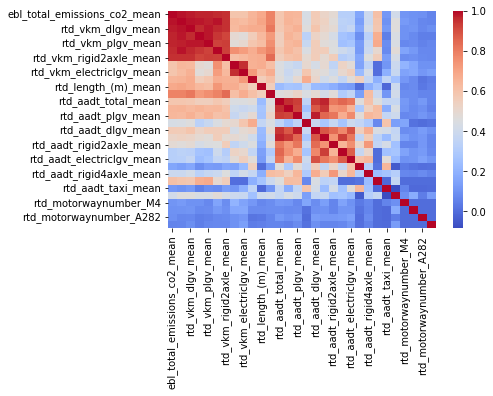

In [34]:
%%time

df_correlations['sum'] = df_correlations['pearson_co2'] + df_correlations['spearman_co2'] + df_correlations['kendall_co2']
df_correlations = df_correlations.nlargest(30,'sum')

selected_columns = df_correlations.index
print(selected_columns)

df_processed = df_processed[df_correlations.index]

# Generate correlation heatmap
data_corr = df_processed.corr()
sns.heatmap(data_corr, cmap='coolwarm')

The heatmap clearly visualises some strong positive and negative correlations across the different features. We will examine each of these further using scatterplots.

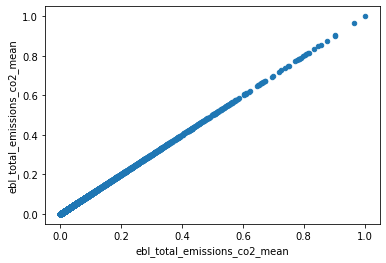

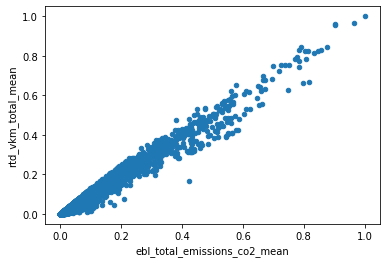

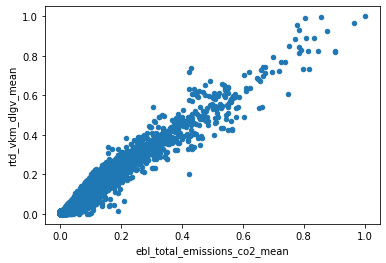

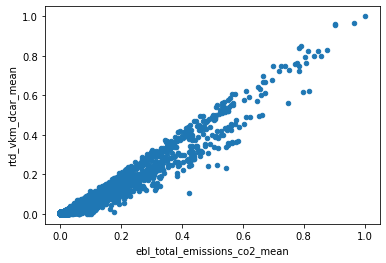

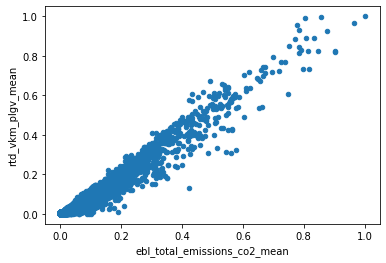

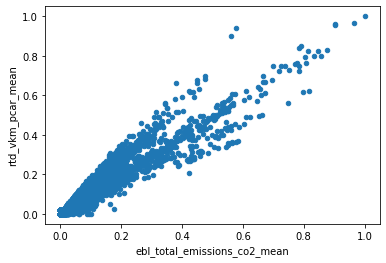

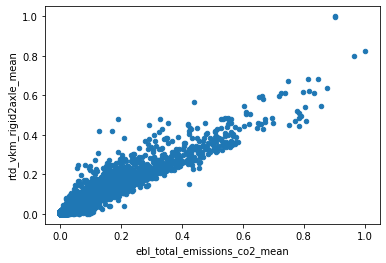

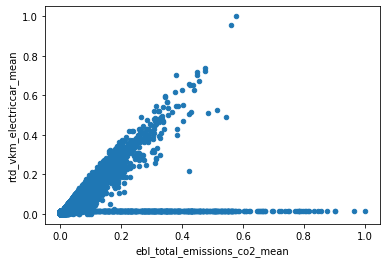

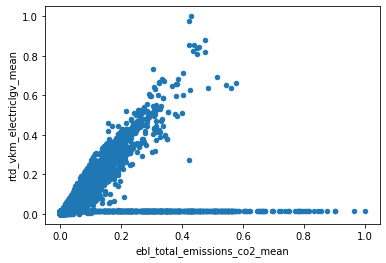

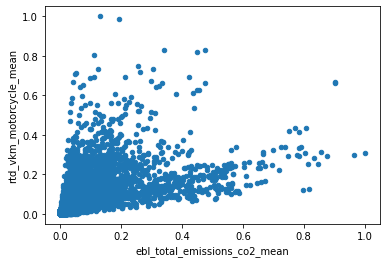

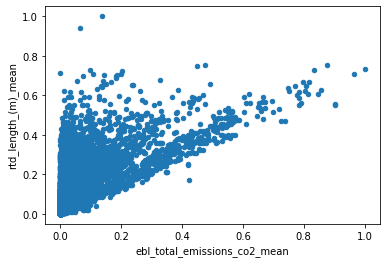

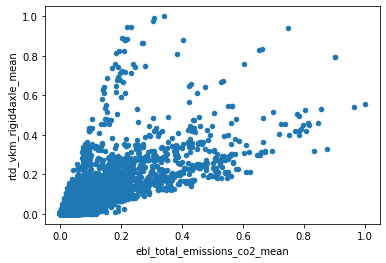

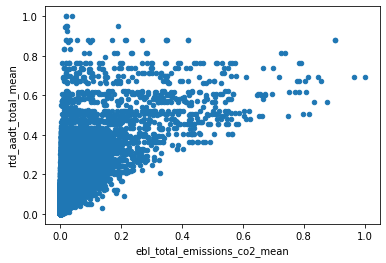

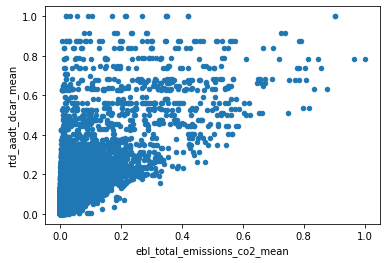

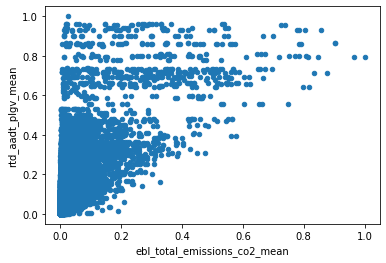

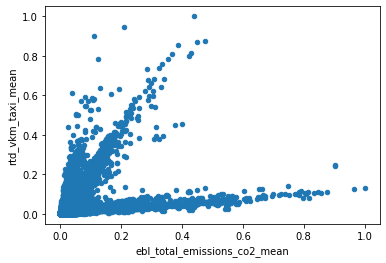

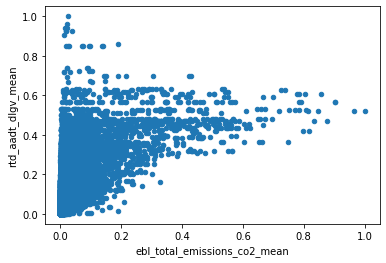

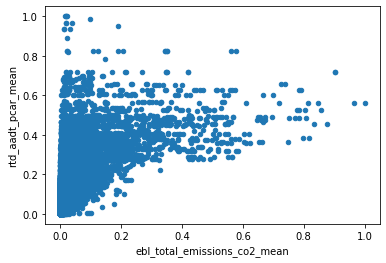

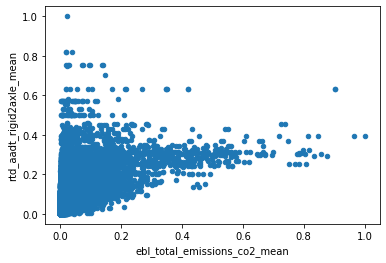

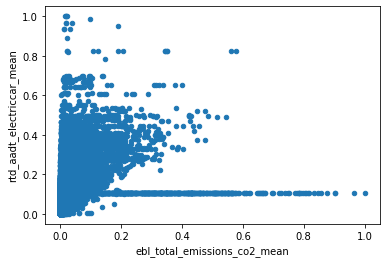

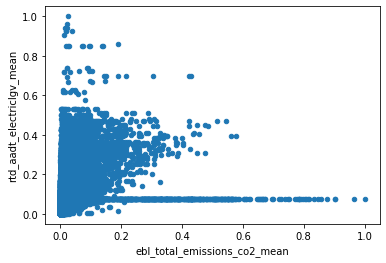

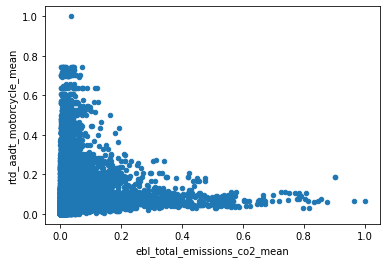

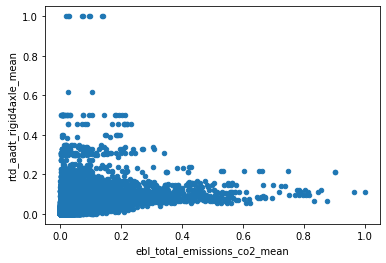

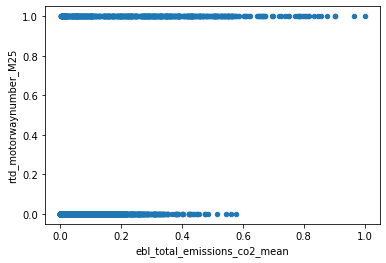

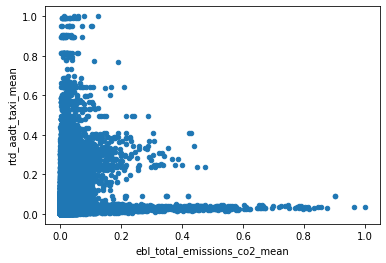

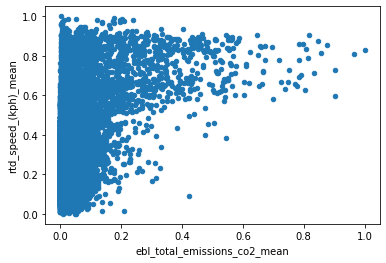

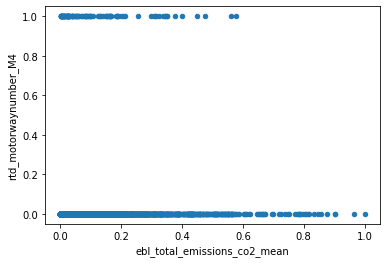

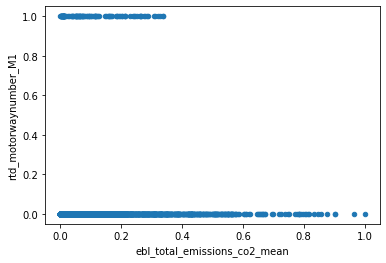

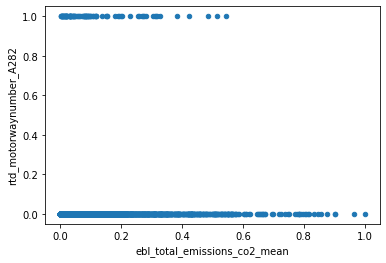

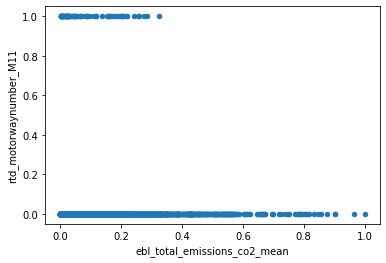

In [35]:
# Produce scatterplots for each feature
for c in selected_columns:
    df_processed.plot.scatter("ebl_total_emissions_co2_mean", c)

### 3.2.3 Final Feature Selection
Since VKm is calculated from AADT, including both columns for each vehicle would result in overfitting within the features. From the visualisations VKm appears to have a clearer shape of correlation and so those columns will be selected over the aadt columns. This leaves the final chosen columns as below. Total VKm, speed and length are also removed for the same reasons.

In [36]:
# Chosen feature columns to train
columns = ['rtd_vkm_dlgv_mean',
           'rtd_vkm_dcar_mean',
           'rtd_vkm_plgv_mean',
           'rtd_vkm_pcar_mean',
           'rtd_vkm_rigid2axle_mean',
           'rtd_vkm_motorcycle_mean',
           'rtd_vkm_rigid4axle_mean',
           'rtd_vkm_taxi_mean',
           'rtd_motorwaynumber_M25',
           'rtd_motorwaynumber_M4',
           'rtd_motorwaynumber_M1',
           'rtd_motorwaynumber_A282',
           'rtd_motorwaynumber_M11']

# 4. Creating Machine Learning Models
This final section is to put together different types of machine learning models using the chosen features and processed dataset and compare the overall results.

## 4.1 Testing Model Types
We selected three different machine learning models to test
- Linear Regression
- Random Forest
- Support Vector Regression

### 4.1.1 Setup

Firstly we define the features and the label, and split the data into test and train samples.

In [37]:
# Define the selected columns

# X_columns
X_columns = columns

# Define the target
y_column = 'ebl_total_emissions_co2_mean'

X = df_processed[X_columns].copy()
y = df_processed[y_column].copy()

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.1.2 Training the models
We train each model using the training data sample and then test the accuracy using the test sample. In order to measure results for each model we calculate:
- Mean Squared Error
- Root Mean Square Error
- Mean Absolute Error
- R-Squared

In [38]:
%%time

# Linear Regression

lr_results = []

l_reg = LinearRegression().fit(X_train, y_train)

y_pred_lr = l_reg.predict(X_test)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

lr_results.append(lr_mse)
lr_results.append(lr_rmse)
lr_results.append(lr_mae)
lr_results.append(lr_r2)


# Random Forest

rf_results = []

rf_reg = RandomForestRegressor().fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_results.append(rf_mse)
rf_results.append(rf_rmse)
rf_results.append(rf_mae)
rf_results.append(rf_r2)


# Support Vector Regression

sv_results = []

sv_reg = SVR().fit(X_train, y_train)

y_pred_sv = sv_reg.predict(X_test)

sv_mse = mean_squared_error(y_test, y_pred_sv)
sv_rmse = mean_squared_error(y_test, y_pred_sv, squared=False)
sv_mae = mean_absolute_error(y_test, y_pred_sv)
sv_r2 = r2_score(y_test, y_pred_sv)

sv_results.append(sv_mse)
sv_results.append(sv_rmse)
sv_results.append(sv_mae)
sv_results.append(sv_r2)


# Results

# Add predictions to test set
predicted_data = X_test
predicted_data['y_pred_lr'] = y_pred_lr 
predicted_data['y_pred_rf'] = y_pred_rf
predicted_data['y_pred_sv'] = y_pred_sv
predicted_data['y_pred_real'] = y_test

# Compiling statistics

columns = ["Linear Regression", "Random Forest", "Support Vector Regression"]
index = ["MSE", "RMSE", "MAE", "R2"]

all_results = pd.DataFrame(zip(lr_results, rf_results, sv_results), index=index, columns=columns)
all_results

CPU times: total: 44.2 s
Wall time: 44.2 s


,Linear Regression,Random Forest,Support Vector Regression
MSE,0.000038,0.000026,0.007288
RMSE,0.006172,0.005116,0.085370
MAE,0.002881,0.002216,0.084089
R2,0.974875,0.982733,-3.807551


## 4.2 Analysing the results
Going forward we will examine to two highest performing models, Linear Regression and Random Forest. In order to compare the two we will perform cross-validation (CV) and visualise the results

### 4.2.1 Visualising the Results
To examine the effectiveness of the predictions we will plot the real value vs the predicted value for the test datasets. We will use the feature rtd_vkm_dcar_mean as an example

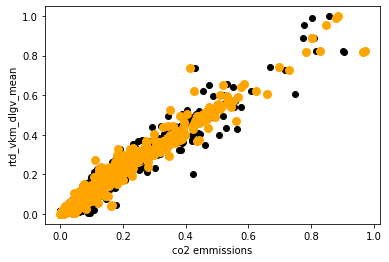

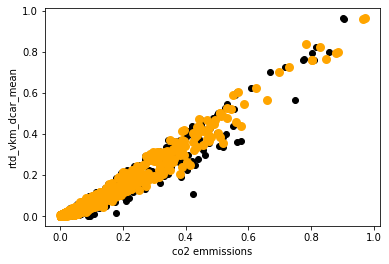

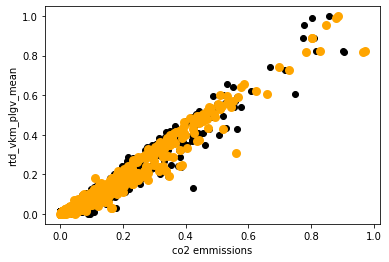

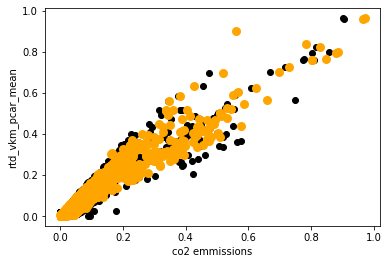

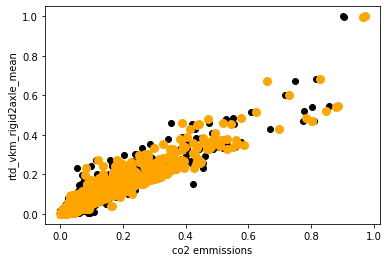

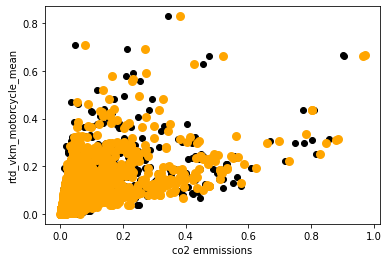

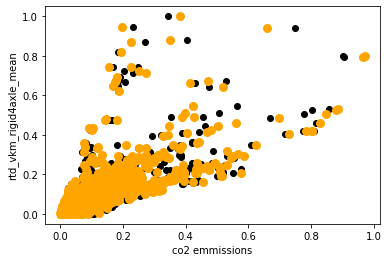

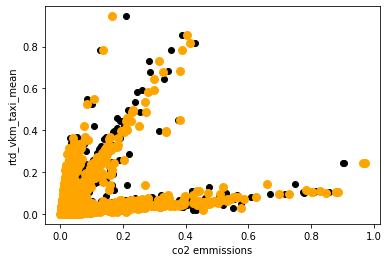

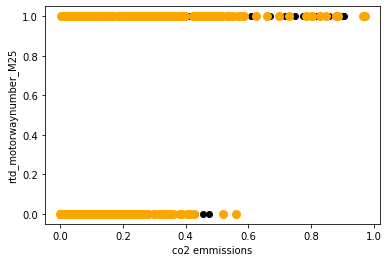

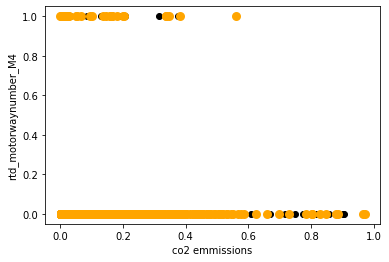

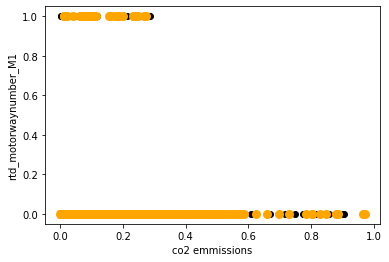

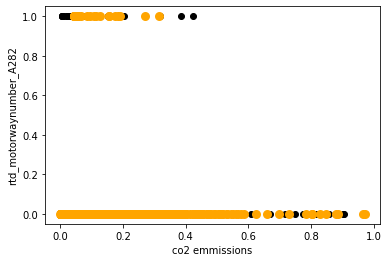

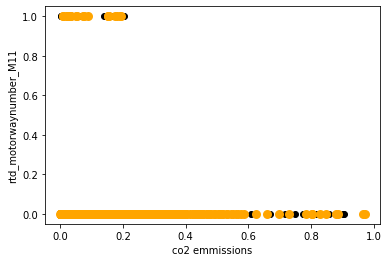

In [40]:
# Linear Regression


# Produce scatterplots for features
for c in X_test.iloc[: , :-4]:
    plt.scatter(predicted_data['y_pred_real'], predicted_data[c], color="black")
    plt.scatter(predicted_data['y_pred_lr'], predicted_data[c], color="orange", linewidth=3)
    plt.xlabel("co2 emmissions")
    plt.ylabel(c)
    plt.show()

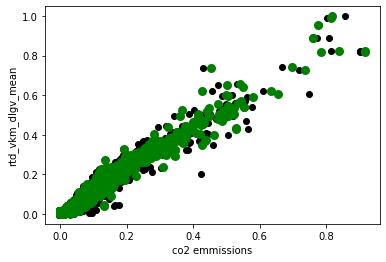

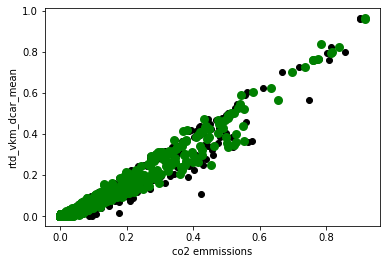

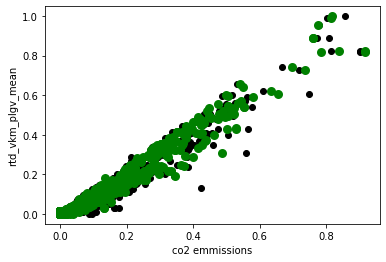

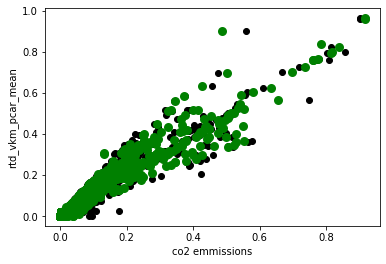

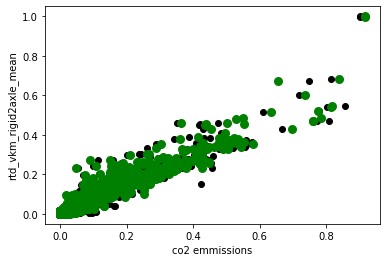

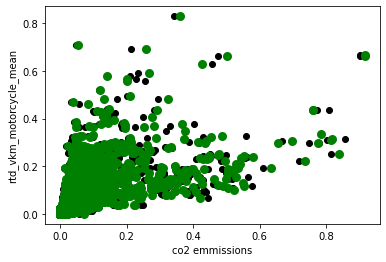

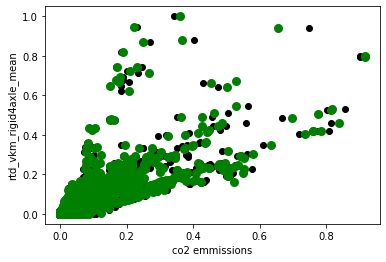

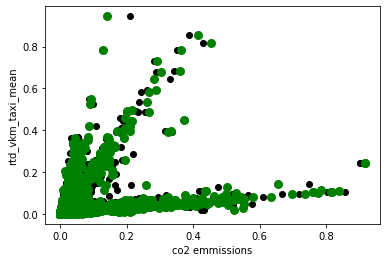

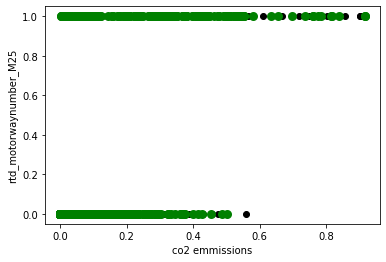

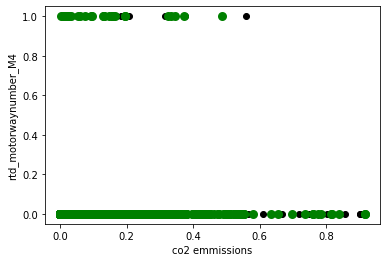

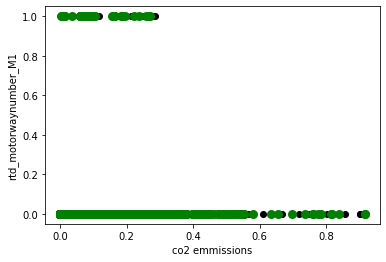

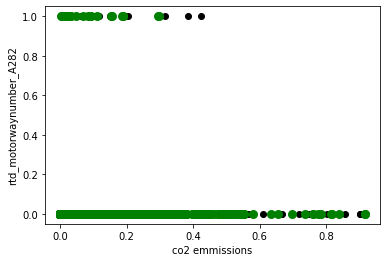

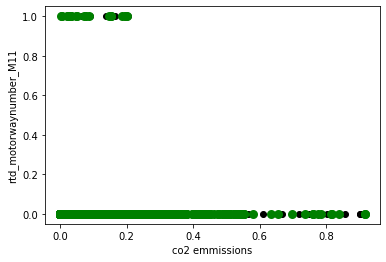

In [41]:
# Random Forest

# Produce scatterplots for features
for c in X_test.iloc[: , :-4]:
    plt.scatter(predicted_data['y_pred_real'], predicted_data[c], color="black")
    plt.scatter(predicted_data['y_pred_rf'], predicted_data[c], color="green", linewidth=3)
    plt.xlabel("co2 emmissions")
    plt.ylabel(c)
    plt.show()

The visualisations give very similar results.

### 4.2.2 Cross-validation
Focussing on the R2 score, we will cross validate the two models.

In [47]:
%%time

# Set what to validate
scores = ["r2"]

def mean(list):
    return sum(list) / len(list)

# Linear Regression 5-fold cross validation 
cv_results_lr = cross_validate(LinearRegression(), X, y, cv=5, scoring=scores)
cv_results_lr_st = list(cv_results_lr['score_time'])
cv_results_lr_st.append(mean(cv_results_lr_st))
cv_results_lr_r2 = list(cv_results_lr['test_r2'])
cv_results_lr_r2.append(mean(cv_results_lr_r2))

# Random Forest 5-fold cross validation
cv_results_rf = cross_validate(RandomForestRegressor(), X, y, cv=5, scoring=scores)
cv_results_rf_st = list(cv_results_rf['score_time'])
cv_results_rf_st.append(mean(cv_results_rf_st))
cv_results_rf_r2 = list(cv_results_rf['test_r2'])
cv_results_rf_r2.append(mean(cv_results_rf_r2))

# Compiling Cross-validation results

index1 = ["st_1", "st_2", "st_3", "st_4", "st_5", "avg_st"] 
index2 = ["r2_1", "r2_2", "r2_3", "r2_4", "r2_5", "avg_r2"]
columns = ["Linear Regression", "Random Forest"]

CPU times: total: 46.8 s
Wall time: 46.8 s


In [43]:
all_st_results = pd.DataFrame(zip(cv_results_lr_st, cv_results_rf_st), index=index1, columns=columns)
all_st_results

,Linear Regression,Random Forest
st_1,0.002992,0.362000
st_2,0.001997,0.424864
st_3,0.001999,0.415888
st_4,0.002990,0.387959
st_5,0.003587,0.401926
avg_st,0.002713,0.398527


In [44]:
all_r2_results = pd.DataFrame(zip(cv_results_lr_r2, cv_results_rf_r2), index=index2, columns=columns)
all_r2_results

,Linear Regression,Random Forest
r2_1,0.970697,0.966821
r2_2,0.823296,0.879592
r2_3,0.818991,0.882858
r2_4,0.866388,0.951574
r2_5,0.972967,0.984191
avg_r2,0.890468,0.933007


Based on the cross-validation results, it appears that the Random Forest performs better on average, although takes significantly longer to train.

### 4.2.3 Simplistic Model
Given the majority of the features included were measures of VKm, we will test a reduced model with the included features and only the total vkm column.

In [45]:
# Chosen feature columns to train
columns = ['rtd_vkm_total_mean',
           'rtd_motorwaynumber_M25',
           'rtd_motorwaynumber_M4',
           'rtd_motorwaynumber_M1',
           'rtd_motorwaynumber_A282',
           'rtd_motorwaynumber_M11']

# Define the selected columns

# X_columns
X_columns = columns

# Define the target
y_column = 'ebl_total_emissions_co2_mean'

X = df_processed[X_columns].copy()
y = df_processed[y_column].copy()

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest

rf_results_simple = []

rf_reg = RandomForestRegressor().fit(X_train_s, y_train_s)

y_pred_rf_s = rf_reg.predict(X_test_s)

rf_mse_s = mean_squared_error(y_test_s, y_pred_rf_s)
rf_rmse_s = mean_squared_error(y_test_s, y_pred_rf_s, squared=False)
rf_mae_s = mean_absolute_error(y_test_s, y_pred_rf_s)
rf_r2_s = r2_score(y_test_s, y_pred_rf_s)

rf_results_simple.append(rf_mse_s)
rf_results_simple.append(rf_rmse_s)
rf_results_simple.append(rf_mae_s)
rf_results_simple.append(rf_r2_s)

# Add predictions to test set
predicted_data_s = X_test_s
predicted_data_s['y_pred_rf_s'] = y_pred_rf_s
predicted_data_s['y_pred_real'] = y_test_s

# Add Statistics to original table
all_results['Random Forest (Simple)'] = rf_results_simple

all_results

,Linear Regression,Random Forest,Support Vector Regression,Random Forest (Simple)
MSE,0.000038,0.000026,0.007288,0.000047
RMSE,0.006172,0.005116,0.085370,0.006891
MAE,0.002881,0.002216,0.084089,0.003029
R2,0.974875,0.982733,-3.807551,0.968675


In [48]:
# Random Forest 5-fold cross validation
cv_results_rf_s = cross_validate(RandomForestRegressor(), X, y, cv=5, scoring=scores)
cv_results_rf_s_st = list(cv_results_rf_s['score_time'])
cv_results_rf_s_st.append(mean(cv_results_rf_st))
cv_results_rf_s_r2 = list(cv_results_rf_s['test_r2'])
cv_results_rf_s_r2.append(mean(cv_results_rf_r2))

all_st_results['Random Forest (Simple)'] = cv_results_rf_s_st
all_st_results

,Linear Regression,Random Forest,Random Forest (Simple)
st_1,0.002992,0.362000,0.370010
st_2,0.001997,0.424864,0.420841
st_3,0.001999,0.415888,0.444842
st_4,0.002990,0.387959,0.383007
st_5,0.003587,0.401926,0.405881
avg_st,0.002713,0.398527,0.410308


In [49]:
all_r2_results['Random Forest (Simple)'] = cv_results_rf_s_r2
all_r2_results

,Linear Regression,Random Forest,Random Forest (Simple)
r2_1,0.970697,0.966821,0.962255
r2_2,0.823296,0.879592,0.800827
r2_3,0.818991,0.882858,0.825887
r2_4,0.866388,0.951574,0.918602
r2_5,0.972967,0.984191,0.970341
avg_r2,0.890468,0.933007,0.894945


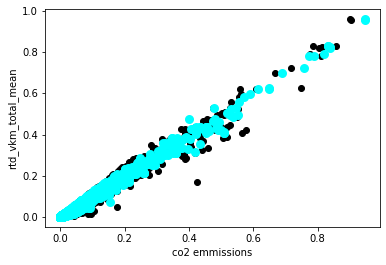

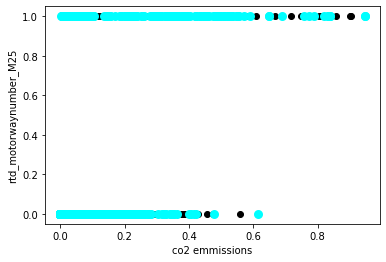

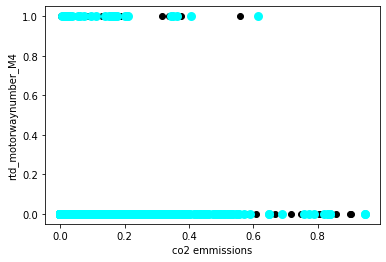

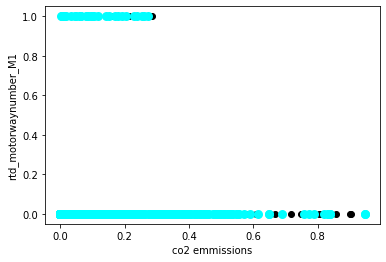

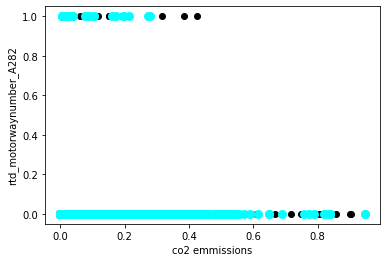

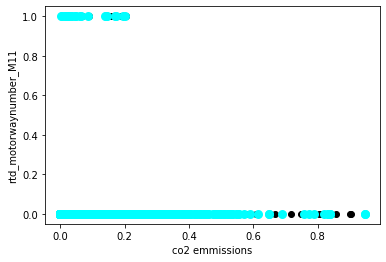

In [50]:
for c in X_test_s.iloc[: , :-2]:
    plt.scatter(predicted_data_s['y_pred_real'], predicted_data_s[c], color="black")
    plt.scatter(predicted_data_s['y_pred_rf_s'], predicted_data_s[c], color="cyan", linewidth=3)
    plt.xlabel("co2 emmissions")
    plt.ylabel(c)
    plt.show()

The results are similar to the full model, and the reduction in required features may be an advantage for when using the model to predict the emissions of links in the future.